# Training a Classifier

With the structure of a neural network defined, the mechanisms of learning understood, the next question is:

## What about data?
Generally, when we have to deal with image, audio or video data, we can use standard python packages that load data into a numpy array. Then we can convert this array into a `torch.*Tensor`.
- For imager, packages such as Pillow and OpenCV are useful
- For audio, packages such as scipy and librosa
- For text, eiher raw Python or Cython based loading, or NLTK  and SpaCy are useful

Specifically for vision, there is a created package called `torchvision`, that has data loaders for common datasets such as ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use CIFAR10. A set of 3-channel colour images of 32x32 pixels, with 10 labels corresponding to "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "ship", "truck".

![](https://pytorch.org/tutorials/_images/cifar10.png)

## Train an Image Classifier
We will do the following steps in order:
1. Load and normalize the CIFAR10 training and test dataset using `torchvision`
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the neural network on the training data
5. Test the network on the test data

## 1. Load and Normalize CIFAR10
Using `torchvision`, it's extremely easy to load CIFAR10.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0,1]. We transform them to Tensors of normalized range [-1, 1].

Note:
If running on Windows and get a BrokenPipeError, try setting the num_worker of torch.utils.data.DataLaoder() to 0.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's show some of the images as a sanity check:

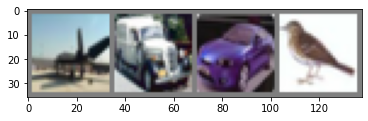

plane truck car   bird 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 + 0.5 # reverse normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# show labels
print (' '.join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

## 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to take 3-channel images instead of 1.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all except batch dim
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

## 3. Define a Loss Function and Optimizer
Let's use a classification croww entropy loss and SGD with momentum


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

## 4. Train the Network
This is where the bulk of the computations come in, and where learning actually happens. We loop over our data iterator, and feed inputs in batches to the network, which the model takes and optimizes over time.

In [6]:
for epoch in range(2):
    
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion (outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print (f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss/2000:.3f}")
            running_loss = 0
            
print ("Finished Training")

[1,  2000] loss: 2.122
[1,  4000] loss: 1.991
[1,  6000] loss: 1.946
[1,  8000] loss: 1.976
[1, 10000] loss: 1.959
[1, 12000] loss: 1.969
[2,  2000] loss: 1.949
[2,  4000] loss: 1.997
[2,  6000] loss: 1.995
[2,  8000] loss: 1.984
[2, 10000] loss: 2.004
[2, 12000] loss: 1.994
Finished Training


We can then save our model:

In [7]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

The pytorch.org documentation [here](https://pytorch.org/docs/stable/notes/serialization.html) provides more details on saving models.

## 5. Test the Network on Test Data
We have trained the network for 2 passes over the training set. Next we need to check if the network has learnt to perform the task.

We check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

First, let's display an image from the test set to get familiar.

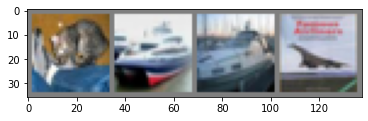

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# Print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model wasn't necessary here, we only did it to illustrate how to do so):

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Now let's see what the neural network thinks these examples above are:

In [10]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let's get the index of the highest energy:

In [11]:
_, predicted = torch.max(outputs, 1)

print ('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  car   ship  car   ship 


The results seem good.

Let's look at how the network performs on the whole dataset.

In [12]:
correct = 0
total = 0

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print (f'Accuracy of the network on the 10,000 test images: {100*correct // total}%')

Accuracy of the network on the 10,000 test images: 27%


That looks better than chance (10%), meaning the network indeed learnt something.

What about the other classes?

In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 28.5 %
Accuracy for class: car   is 60.1 %
Accuracy for class: bird  is 17.5 %
Accuracy for class: cat   is 0.1 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 27.3 %
Accuracy for class: frog  is 73.7 %
Accuracy for class: horse is 16.1 %
Accuracy for class: ship  is 40.8 %
Accuracy for class: truck is 7.8 %


Next, we do the computation on the GPU

## Training on GPU

Just like how we transfer a Tensor onto the GPU, we can transfer the neural network onto the GPU.

FIrst, we define out devices as the first visible CUDA device if we have CUDA available:

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print (device)

net.to(device)

cuda


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Remember that we have to send the inputs and targets at every step to the GPU too:

In [15]:
inputs, labels = data[0].to(device), data[1].to(device)

In small networks like the example `net` above, there isn't much performance increase.

In [16]:
del dataiter